In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import multiprocessing

# Disable CUDA because only one gpu device allows only a single chain
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)
import jax

jax.default_backend()
jax.devices()

2023-07-23 23:39:09.933032: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]

In [3]:
from yomi_skill.model import YomiModel, weight_by
from yomi_skill.models import *
from yomi_skill.models.mu_glicko import *
from yomi_skill.yomi import historical_record
import pandas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tempfile

from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, cross_validate

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [4]:
fit_dir = tempfile.mkdtemp()

In [5]:
tournament_games = historical_record.latest_tournament_games()
sirlin_games = historical_record.sirlin_db()
games = pandas.concat([tournament_games, sirlin_games]).reset_index(drop=True)

games

,match_date,player_1,character_1,win,character_2,player_2,public
0,2014-07-06 00:00:00,Jengajam,menelker,0,setsuki,fodazd,True
1,2014-07-06 00:00:00,MadKing,quince,1,setsuki,CKR,True
2,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
3,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
4,2014-07-06 00:00:00,Raziek,zane,1,quince,MadKing,True
...,...,...,...,...,...,...,...
120301,2015-09-07 19:11:01,DarkSephiroth,menelker,0,valerie,BONZAI,False
120302,2015-09-07 19:09:31,Kirandio,degrey,0,menelker,pfiidude,False
120303,2015-09-07 19:17:11,hartley,valerie,0,rook,EricF,False
120304,2015-09-07 19:17:43,DarkSephiroth,menelker,0,valerie,BONZAI,False


In [6]:
games = historical_record.augment_dataset(games)

Constructing PC category


In [7]:
min_games = 0
warmup = 500
samples = 1000

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    games, games.win.astype('int'),
)

In [9]:
MODELS = {
    model.model_name: model
    for model_type in YomiModel.__subclasses__()
    for model in model_type.__subclasses__()
}

In [10]:
MODELS

{'mu_pc_glicko': yomi_skill.models.mu_pc_glicko.MUPCGlicko,
 'pc_elo': yomi_skill.models.pc_elo.PCElo,
 'mu_pc_elo_c': yomi_skill.models.mu_pc_elo_c.MUPCEloC,
 'char_skill_skelo_skill_deficit': yomi_skill.models.char_skill_skelo_skill_deficit.CharSkillSkeloSkillDeficit,
 'mu': yomi_skill.models.mu_only.MUOnly,
 'glicko': yomi_skill.models.glicko.Glicko,
 'elo': yomi_skill.models.elo.Elo,
 'mu_pc_elo_vol': yomi_skill.models.mu_pc_elo_vol.MUPCEloVol,
 'char_skill_glicko_skill_deficit': yomi_skill.models.char_skill_glicko_skill_deficit.CharSkillGlickoSkillDeficit,
 'mu_pc_elo': yomi_skill.models.mu_pc_elo.MUPCElo,
 'full': yomi_skill.models.full.Full,
 'mu_elo': yomi_skill.models.mu_elo.MUElo,
 'mu_glicko': yomi_skill.models.mu_glicko.MUGlicko,
 'pc_glicko': yomi_skill.models.pc_glicko_only.PCGlicko}

In [11]:
model_names = [
    'full',
    # 'mu',
    # 'elo',
    # 'mu_elo',
    # 'pc_elo',
    # 'mu_pc_elo',
    # 'mu_pc_elo_vol',
    # 'mu_pc_elo_c',
    # 'glicko',
    # 'mu_glicko',
    # 'pc_glicko',
    # 'mu_pc_glicko',
]
models = {model_name: MODELS[model_name](min_games=min_games, warmup=warmup, samples=samples) for model_name in model_names}

In [12]:
pipelines = {}
# pipelines['full'] = models['full'].pipeline(
#         transform__elo__initial_time=games.match_date.min(),
#         transform__pc_elo__initial_time=games.match_date.min(),
#         model__min_games=min_games,
#         model__warmup=warmup,
#         model__samples=samples,
#     )

pipelines['full2'] = models['full'].pipeline(
        transform__elo__initial_time=games.match_date.min(),
        transform__pc_elo__initial_time=games.match_date.min(),
        model__min_games=min_games,
        model__warmup=warmup,
        model__samples=samples,
        transform__elo__default_k=16,
        transform__pc_elo__default_k=1
    )
# pipelines['mu_elo'] = models['mu_elo'].pipeline(
#         transform__elo__initial_time=games.match_date.min(),
#         model__min_games=min_games,
#         model__warmup=warmup,
#         model__samples=samples,
#     )
# pipelines['mu_pc_elo'] = models['mu_pc_elo'].pipeline(
#         transform__pc_elo__initial_time=games.match_date.min(),
#         model__min_games=min_games,
#         model__warmup=warmup,
#         model__samples=samples,
#     )

In [13]:
from sklearn import set_config
set_config(transform_output="pandas")

In [14]:
for model_name in ['full2']:
    pipelines[model_name].fit(
        X_train,
        y_train,
        # sample_weight=X_train[f'{models[model_name].weight_key}_weight']
    )

Compiling...
Compilation time =  0:00:03.720096
Sampling...
Sampling time =  0:00:05.561213
Transforming variables...
Transformation time =  0:02:41.442359


In [17]:
from yomi_skill.render import *
render = YomiRender(pipelines['full2'])
display(pipelines['full2']['model'].data_)
filename = render.render_matchup_comparator('src-site/src/data/yomi')
print(filename)


,elo__prob,elo__r1,elo__r2,pc_elo__prob,pc_elo__r1,pc_elo__r2,min_games__player_1_orig,min_games__player_2_orig,min_games__player_1,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,render__match_date,render__win,render__public
119974,0.568225,1540.085302,1492.379814,0.528326,1490.416666,1470.712892,Legion,Kraetyz,Legion,Kraetyz,False,False,argagarg-vendetta,argagarg,vendetta,1,2015-09-04 11:00:24,0,False
95952,0.511818,1471.583447,1463.370191,0.504052,1499.499280,1496.683585,❤ White Girl Music,1gbofpr0n,❤ White Girl Music,1gbofpr0n,False,False,setsuki-persephone,setsuki,persephone,1,2015-05-11 05:56:46,0,False
46811,0.363868,1554.328848,1651.370310,0.473736,1495.162607,1513.429214,Nashun,IamNobody,Nashun,IamNobody,False,False,vendetta-troq,vendetta,troq,1,2014-01-01 03:41:16,0,False
69989,0.476333,1528.656230,1545.113932,0.500087,1501.494612,1501.433882,gwwak,rodohk,gwwak,rodohk,False,False,argagarg-gwen,argagarg,gwen,1,2014-08-08 23:17:07,1,False
115959,0.552213,1663.909653,1627.495893,0.586637,1558.210068,1497.394961,Nashun,Staryu,Nashun,Staryu,False,False,rook-jaina,rook,jaina,1,2015-08-01 04:49:36,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52258,0.752093,1670.638944,1477.845831,0.511287,1507.844403,1500.000000,vsbr,"Kristoph, the Angel",vsbr,"Kristoph, the Angel",False,False,lum-gloria,lum,gloria,1,2014-04-03 08:49:49,0,False
119461,0.455527,1553.021095,1584.006021,0.504676,1501.329345,1498.080137,va・gi・na_gi・na,drnd,va・gi・na_gi・na,drnd,False,False,geiger-gloria,geiger,gloria,1,2015-08-30 12:14:29,1,False
117486,0.211339,1508.699849,1737.463637,0.469580,1499.529069,1520.693107,Cosmicolor,deluks917,Cosmicolor,deluks917,False,False,jaina-zane,jaina,zane,1,2015-08-15 18:52:24,0,False
79308,0.457602,1545.167535,1574.699670,0.491244,1497.388832,1503.473410,mysticjuicer,enomus,mysticjuicer,enomus,False,False,rook-lum,rook,lum,1,2014-12-22 17:25:22,1,False


Computing per-player data for 338 players


player
Southpaw Hare    2509
HawkRose           70
Gingivitusks       48
fodazd            507
Leontes           890
                 ... 
Chase               7
GeckoTH            10
Lawlzard           61
pheonix123          3
Rox Robstah       497
Length: 338, dtype: int64

Computing matchup dict
Computing player skill
None


In [41]:
pred_test = {
    model_name: pipelines[model_name].predict_proba(X_test)[:, 1]
    for model_name in ['full2']
    if hasattr(pipelines[model_name]['model'], 'inf_data_')
}

['grave-grave', 'grave-midori', 'grave-rook', 'grave-valerie', 'grave-lum', 'grave-jaina', 'grave-setsuki', 'grave-degrey', 'grave-geiger', 'grave-argagarg', 'grave-quince', 'grave-bbb', 'grave-menelker', 'grave-gloria', 'grave-vendetta', 'grave-onimaru', 'grave-troq', 'grave-persephone', 'grave-gwen', 'grave-zane', 'midori-midori', 'midori-rook', 'midori-valerie', 'midori-lum', 'midori-jaina', 'midori-setsuki', 'midori-degrey', 'midori-geiger', 'midori-argagarg', 'midori-quince', 'midori-bbb', 'midori-menelker', 'midori-gloria', 'midori-vendetta', 'midori-onimaru', 'midori-troq', 'midori-persephone', 'midori-gwen', 'midori-zane', 'rook-rook', 'rook-valerie', 'rook-lum', 'rook-jaina', 'rook-setsuki', 'rook-degrey', 'rook-geiger', 'rook-argagarg', 'rook-quince', 'rook-bbb', 'rook-menelker', 'rook-gloria', 'rook-vendetta', 'rook-onimaru', 'rook-troq', 'rook-persephone', 'rook-gwen', 'rook-zane', 'valerie-valerie', 'valerie-lum', 'valerie-jaina', 'valerie-setsuki', 'valerie-degrey', 'vale

In [42]:
df_pred_test = pandas.DataFrame(pred_test)

,elo__prob,elo__r1,elo__r2,pc_elo__prob,pc_elo__r1,pc_elo__r2,min_games__player_1_orig,min_games__player_2_orig,min_games__player_1,min_games__player_2,min_games__min_games_player_1,min_games__min_games_player_2,matchup__mup,matchup__character_1,matchup__character_2,matchup__non_mirror,render__match_date,render__win,render__public
58927,0.442870,1486.518989,1526.391002,0.493078,1497.593404,1502.403749,Dixon,Dantes,Dixon,Dantes,False,False,troq-troq,troq,troq,0,2014-05-24 14:45:10,1,False
20994,0.369350,1532.634698,1625.575065,0.497278,1500.516048,1502.407171,ArthurWynne,flagrantangles,ArthurWynne,flagrantangles,False,False,troq-gwen,troq,gwen,1,2018-08-13 00:00:00,0,True
20469,0.322604,1492.082219,1620.951243,0.470318,1499.016723,1519.666469,Luke1705,Dietz,Luke1705,Dietz,False,False,midori-lum,midori,lum,1,2018-06-24 00:00:00,0,True
16590,0.390298,1491.556726,1569.045529,0.497858,1499.499280,1500.987534,Ivan,flagrantangles,Ivan,flagrantangles,False,False,jaina-persephone,jaina,persephone,1,2017-06-30 00:00:00,0,True
117612,0.619172,1584.572166,1500.139010,0.488946,1497.859680,1505.541776,drnd,anime witches (2),drnd,anime witches (2),False,False,persephone-persephone,persephone,persephone,0,2015-08-16 17:48:07,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86700,0.765867,1650.125944,1444.249928,0.534266,1520.866616,1497.019012,Yetimacblack,GUSTY,Yetimacblack,GUSTY,False,False,rook-setsuki,rook,setsuki,1,2015-03-08 21:08:06,1,False
4685,0.551891,1650.875229,1614.687097,0.499398,1502.136013,1502.554174,EricF,Bomber678,EricF,Bomber678,False,False,degrey-quince,degrey,quince,1,2015-06-21 00:00:00,1,True
117482,0.563407,1481.592719,1437.294667,0.500275,1495.730146,1495.538870,Cheesemonger,boonifier,Cheesemonger,boonifier,False,False,menelker-gwen,menelker,gwen,1,2015-08-15 18:48:13,0,False
34571,0.656100,1628.520717,1516.305552,0.516781,1503.984154,1492.319003,major_shiznick,Bob199,major_shiznick,Bob199,False,False,degrey-persephone,degrey,persephone,1,2013-07-25 21:31:00,0,False


array([False, False, False, ..., False, False, False])

array([ True, False, False, ..., False, False, False])

0        0.455330
1        0.550997
2        0.352039
3        0.512276
4        0.571640
           ...   
30072    0.757982
30073    0.510474
30074    0.497830
30075    0.674959
30076    0.413461
Name: full2, Length: 30077, dtype: float64

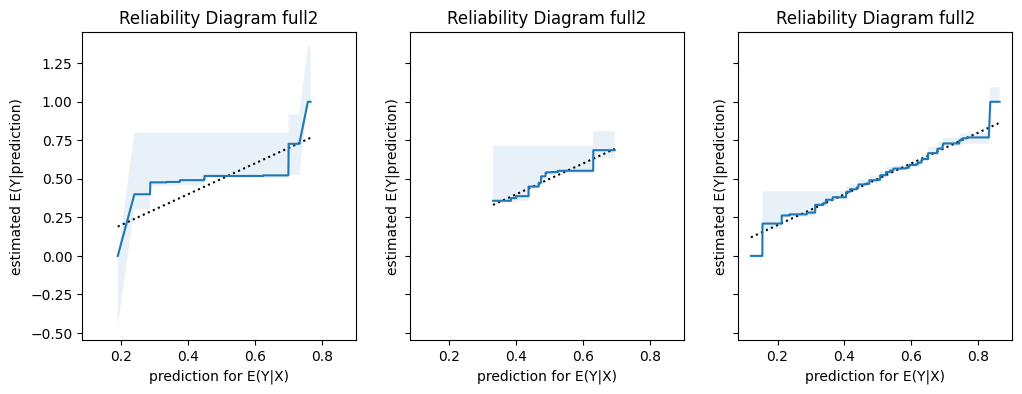

In [57]:
import matplotlib.pyplot as plt
from model_diagnostics.calibration import compute_bias, plot_bias, plot_reliability_diagram
fig, axes = plt.subplots(ncols=3, nrows=len(pred_test), figsize=(12, 4*len(pred_test)), sharex=True, sharey=True)
mirror_matches = (X_test.character_1 == X_test.character_2).to_numpy()

for i, model_name in enumerate(pred_test):
    elo_test = pipelines[model_name]['transform'].transform(X_test)
    display(elo_test)
    near_elo = ((elo_test['elo__prob'] - 0.5).abs() < 0.02).to_numpy()
    display(near_elo)
    display(mirror_matches)
    display(df_pred_test[model_name])
    plot_reliability_diagram(
        y_obs=y_test[mirror_matches],
        y_pred=df_pred_test[model_name][mirror_matches],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[0],
    )
    plot_reliability_diagram(
        y_obs=y_test[near_elo],
        y_pred=df_pred_test[model_name][near_elo],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[1],
    )
    plot_reliability_diagram(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
        n_bootstrap=100,
        ax=axes[2],
    )

<Axes: title={'center': 'Bias Plot full2'}, xlabel='matchup__mup', ylabel='bias'>

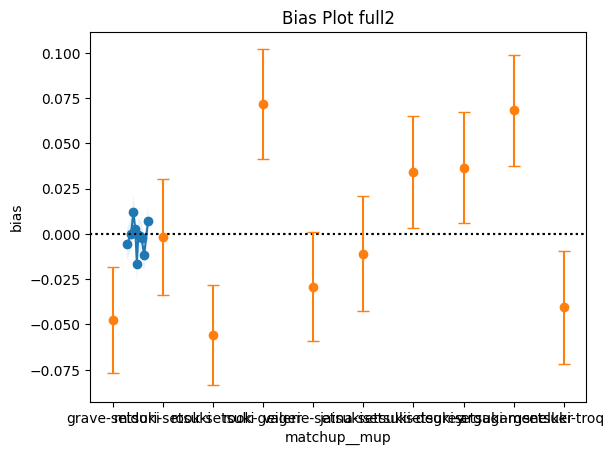

In [51]:
elo_test = pipelines[model_name]['transform'].transform(X_test)
plot_bias(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
    feature=elo_test['elo__prob']
)

<Axes: title={'center': 'Bias Plot full2'}, xlabel='binned matchup__non_mirror', ylabel='bias'>

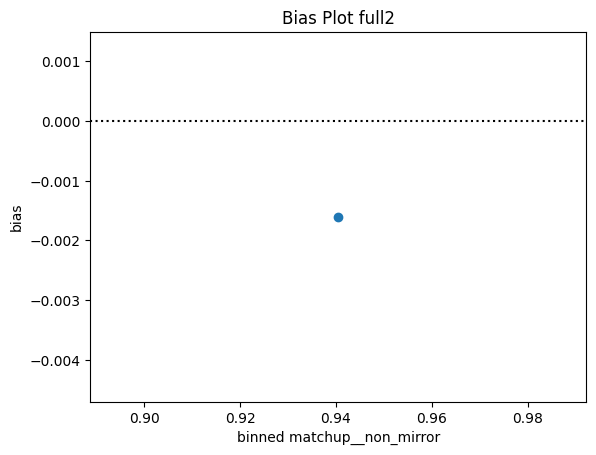

In [56]:

plot_bias(
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
    feature=elo_test['matchup__non_mirror'] == 1
)

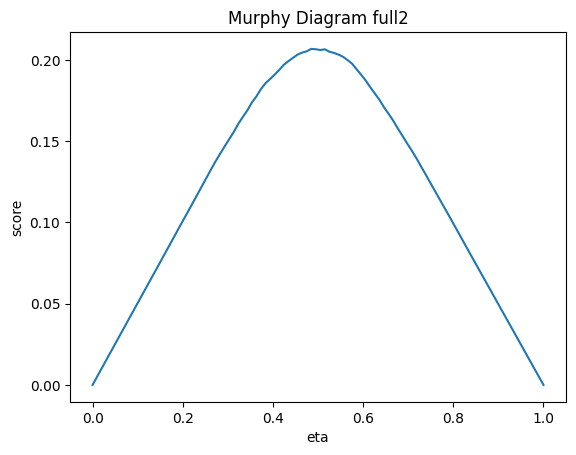

In [23]:
from model_diagnostics.scoring import SquaredError, plot_murphy_diagram

ax = plot_murphy_diagram(
    y_obs=y_test,
    y_pred=df_pred_test,
)

In [24]:
from model_diagnostics.scoring import SquaredError, decompose
import polars as pl

df_list = []
for model_name in df_pred_test:
    df = decompose(
        scoring_function=SquaredError(),
        y_obs=y_test,
        y_pred=df_pred_test[model_name],
        # weights=X_test[models[model_name].weight_key + '_weight'],
    )
    df = df.with_columns(pl.lit(model_name).alias("model"))
    df_list.append(df)
pl.concat(df_list)[:, [-1, 0, 1, 2, 3]]


model,miscalibration,discrimination,uncertainty,score
str,f64,f64,f64,f64
"""full2""",0.000496,0.012021,0.249986,0.238461


In [27]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from scipy.stats import loguniform, uniform
from sklearn.model_selection import GridSearchCV
search = HalvingRandomSearchCV(
    pipelines['full'],
    {
        'transform__elo__default_k': loguniform(15, 80),
        'transform__pc_elo__default_k': loguniform(1, 80),
    },
    scoring='neg_brier_score',
    verbose=2,
    n_candidates=80,
    min_resources='exhaust')
search.fit(games, games.win)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 4455
max_resources_: 120306
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 80
n_resources: 4455
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Compiling...
Compilation time =  0:00:02.466061
Sampling...
Sampling time =  0:00:06.310433
Transforming variables...
Transformation time =  0:00:03.118715
[CV] END transform__elo__default_k=32.471244314414015, transform__pc_elo__default_k=10.132438152022768; total time=  13.9s
Compiling...
Compilation time =  0:00:03.060107
Sampling...


KeyboardInterrupt: 

In [43]:
import arviz
for model in df_pred_test:
    print(model)
    display(pipelines[model]['model'].data_)
    display(arviz.summary(pipelines[model]['model'].inf_data_))

NameError: name 'df_pred_test' is not defined

In [ ]:
import arviz
arviz.plot_pair(models['full'].inf_data_, var_names=['pc_elo_sum_intercept', 'elo_sum_intercept']

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    elo_only,
    hist_games,
    y=hist_games.win,
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss",
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()

In [ ]:
scores = cross_validate(
    full,
    hist_games,
    y=hist_games.win,
    fit_params={'sample_weights': hist_games.weight},
    cv=5,
    scoring=(
        "neg_brier_score",
        "neg_log_loss", 
        "roc_auc",
        "precision",
        "recall",
        "f1",
    ),
)
pandas.DataFrame(scores).describe()